# R4 on DECOY_MNIST

In [16]:
%load_ext autoreload
%autoreload 2
import torch
import tqdm
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('..'))
import abstract_gradient_training as agt
from abstract_gradient_training import AGTConfig
from abstract_gradient_training import certified_training_utils as ct_utils
from models.fully_connected import FCNAugmented
from models.robust_regularizer import input_gradient_interval_regularizer
from models.pipeline import (train_model_with_certified_input_grad, train_model_with_pgd_robust_input_grad,
                             test_model_accuracy, test_delta_input_robustness, write_results_to_file,
                             uniformize_magnitudes_schedule, load_params_or_results_from_file,
                             train_model_with_smoothed_input_grad, test_model_avg_and_wg_accuracy)
from datasets import decoy_mnist
from metrics import get_restart_avg_and_worst_group_accuracy_with_stddev

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# set up pre-training
CUDA_LAUNCH_BLOCKING=1
SEED = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(SEED)

cuda:0


In [3]:
batch_size = 1000
dl_train, dl_test = decoy_mnist.get_dataloaders(train_batchsize=batch_size, test_batchsize=batch_size)

/vol/bitbucket/mg2720/R4/examples/datasets/decoy_mnist.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_imgs = torch.tensor(train_imgs.clone().detach(), dtype=torch.float32) / 255
/vol/bitbucket/mg2720/R4/examples/datasets/decoy_mnist.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_imgs = torch.tensor(test_imgs.clone().detach(), dtype=torch.float32) / 255
/vol/bitbucket/mg2720/R4/examples/datasets/decoy_mnist.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels.clone().detach(),

In [4]:
dl_masks_train, dl_masks_test = decoy_mnist.get_masked_dataloaders(dl_train, dl_test)

Swatches color dict: {0: tensor(0.3333), 1: tensor(0.2980), 2: tensor(0.2667), 3: tensor(0.2353), 4: tensor(0.2000), 5: tensor(0.1686), 6: tensor(0.1373), 7: tensor(0.1020), 8: tensor(0.0706), 9: tensor(0.0392)}


In [5]:
def visualize_gradient(model, batch_input, batch_labels, batch_mask, epsilon, elem_idx):
    batch_input, batch_labels, batch_mask = batch_input.to(device), batch_labels.to(device), batch_mask.to(device)
    grad_bounds = input_gradient_interval_regularizer(
        model, batch_input, batch_labels, "cross_entropy", epsilon, 0.0, return_grads=True, regularizer_type="r4", batch_masks=batch_mask
    )
    dx_l, dx_u = grad_bounds[1]
    dx_n, _ = grad_bounds[0]
    fig, ax = plt.subplots(3, 2, figsize=(14, 13))
    ax[0][0].imshow(batch_input[elem_idx].cpu().numpy().reshape(28, 28), cmap='gray')
    ax[0][0].set_title(f"Input at index {elem_idx}")
    im_mask = ax[0][1].imshow(batch_mask[elem_idx].cpu().numpy().reshape(28, 28), cmap='gray')
    ax[0][1].set_title(f"Mask at index {elem_idx}")
    fig.colorbar(im_mask, ax=ax[0][1])
    im_dx_l = ax[1][0].imshow(dx_l[elem_idx].cpu().detach().numpy().reshape(28, 28), cmap='coolwarm')
    ax[1][0].set_title(f"Lower bound of gradient at index {elem_idx}")
    fig.colorbar(im_dx_l, ax=ax[1][0])
    im_dx_u = ax[1][1].imshow(dx_u[elem_idx].cpu().detach().numpy().reshape(28, 28), cmap='coolwarm')
    ax[1][1].set_title(f"Upper bound of gradient at index {elem_idx}")
    fig.colorbar(im_dx_u, ax=ax[1][1])
    im_dx_n = ax[2][0].imshow(dx_n[elem_idx].cpu().detach().numpy().reshape(28, 28), cmap='coolwarm')
    ax[2][0].set_title(f"Gradient at index {elem_idx}")
    fig.colorbar(im_dx_n, ax=ax[2][0])

In [6]:
ARCH = (784, 10, 512, 1)
model = FCNAugmented(*ARCH, init_with_small_weights=True)
criterion = torch.nn.CrossEntropyLoss()
model = model.to(device)
print(model)

FCNAugmented(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=10, bias=True)
  (4): Softmax(dim=-1)
)


887
torch.Size([10000, 28, 28])


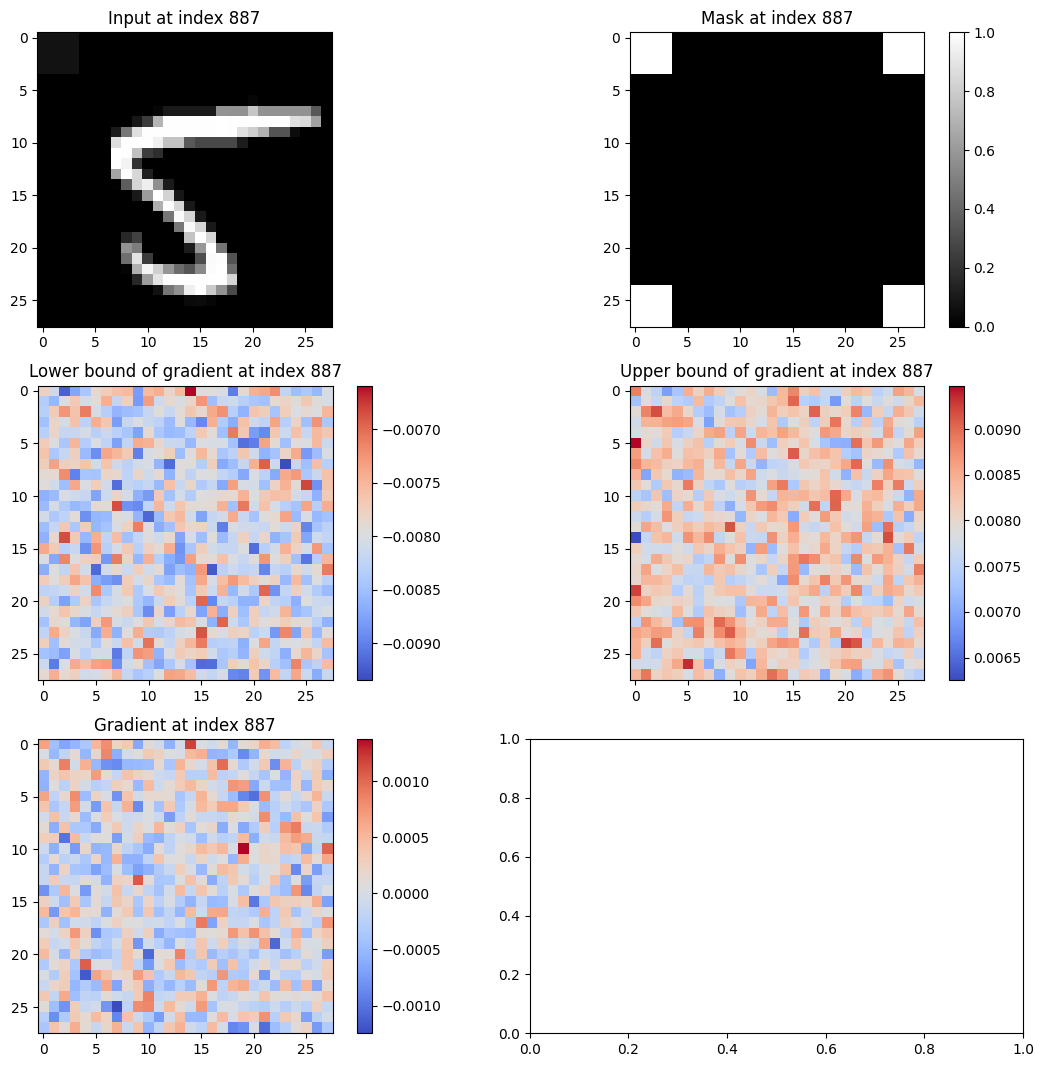

In [8]:
elem_idx = torch.randint(0, batch_size, (1,)).item()
print(elem_idx)
print(dl_masks_test.dataset.tensors[2].shape)
test_batch = list(next(iter(dl_masks_test)))
visualize_gradient(model, test_batch[0], test_batch[1], test_batch[2], 0.1, elem_idx)

## Experiments 

In [9]:
DELTA_INPUT_ROBUSTNESS_PARAM = 0.5
model_root_save_dir = "saved_experiment_models/performance/decoy_mnist/"
os.makedirs(model_root_save_dir, exist_ok=True)
# r4_pmo is the same as r4 but with only the masked region perturbed
methods = ["std", "r3", "r4", "ibp_ex", "ibp_ex+r3", "pgd_r4", "rand_r4", "smooth_r3", "r4_pmo", "pgd_r4_pmo", "rand_r4_pmo"]
save_dir_for_method = {method: os.path.join(model_root_save_dir, method) for method in methods}
for method in methods:
    os.makedirs(save_dir_for_method[method], exist_ok=True)

### Standard Training

In [80]:
std_method = "std"
# hyperparameters
num_epochs, lr, restarts, epsilon, weight_coeff, k = 30, 0.01, 4, 0.1, -1, -1
# Train standard 3 times and test accuracy and delta input robustness for the masked region
train_acc, test_acc, num_robust, avg_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 0, 0, 0
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = FCNAugmented(*ARCH)

    print(f"========== Training model with method {std_method} restart {i} ==========")
    train_model_with_certified_input_grad(dl_masks_train, num_epochs, curr_model, lr, criterion, epsilon, std_method, k, device, False)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_masks_train, device, multi_class=True)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_masks_test, device, multi_class=True)
    n_r, min_delta, m_l, m_u = test_delta_input_robustness(dl_masks_test, curr_model, epsilon, DELTA_INPUT_ROBUSTNESS_PARAM, "cross_entropy", device)
    num_robust += num_robust
    avg_delta += min_delta
    min_lower_bound += m_l
    max_upper_bound += m_u
    avg_g_acc, wg_acc, wg = test_model_avg_and_wg_accuracy(curr_model, dl_masks_test, device, num_groups=10, multi_class=True)
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[std_method], f"run_{i}.pt"))
empty_model = FCNAugmented(*ARCH)
avg_acc, wg_acc, wg, *_ = get_restart_avg_and_worst_group_accuracy_with_stddev(
    dl_masks_test, save_dir_for_method[std_method], empty_model, device, num_groups=10, multi_class=True
)
write_results_to_file("experiment_results/decoy_mnist.yaml",
                      {"train_acc": round(train_acc / restarts, 5),
                       "test_acc": round(test_acc / restarts, 5),
                       "avg_group_acc": round(avg_acc, 5),
                       "worst_group_acc": round(wg_acc, 5),
                       "worst_group": wg,
                       "min_robust_delta": round(avg_delta / restarts, 5),
                       "min_lower_bound": round(min_lower_bound / restarts, 5),
                       "max_upper_bound": round(max_upper_bound / restarts, 5)
                       }, std_method)
write_results_to_file("experiment_results/decoy_mnist_params.yaml",
                        {"epsilon": epsilon,
                         "test_epsilon": epsilon,
                         "k": k,
                         "weight_coeff": weight_coeff,
                         "num_epochs": num_epochs,
                         "lr": lr,
                         "restarts": restarts,
                         "train_batch_size": dl_masks_train.batch_size,
                         "test_batch_size": dl_masks_test.batch_size,
                         "class_weights": -1,
                         "multi_class": True,
                         "has_conv": False,
                         "with_k_schedule": False}, std_method)

========== Training model with method std restart 0 ==========


Epoch: 100%|██████████| 30/30 [00:42<00:00,  1.42s/it, loss=1.46, reg=0]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.9971
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.6398
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 526
--- Model accuracy per group ---
Macro average group accuracy = 0.6423
Min group accuracy = 0.2428, group idx = 9
========== Training model with method std restart 1 ==========


Epoch: 100%|██████████| 30/30 [00:43<00:00,  1.45s/it, loss=1.46, reg=0]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.997
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.6362
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 470
--- Model accuracy per group ---
Macro average group accuracy = 0.6388
Min group accuracy = 0.2002, group idx = 9
========== Training model with method std restart 2 ==========


Epoch: 100%|██████████| 30/30 [00:43<00:00,  1.44s/it, loss=1.46, reg=0]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.9979
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.6195
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 491
--- Model accuracy per group ---
Macro average group accuracy = 0.6213
Min group accuracy = 0.2369, group idx = 9
========== Training model with method std restart 3 ==========


Epoch: 100%|██████████| 30/30 [00:42<00:00,  1.43s/it, loss=1.46, reg=0]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.997
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.6508
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 502
--- Model accuracy per group ---
Macro average group accuracy = 0.6533
Min group accuracy = 0.2161, group idx = 9
Macro average group accuracy = 0.6389
Min group accuracy = 0.224, group idx = 9
Group accuracies averaged over run = tensor([0.6046, 0.6161, 0.7805, 0.7559, 0.7581, 0.8279, 0.7662, 0.6257, 0.4299,
        0.2240], dtype=torch.float64)


### RRR Training

In [ ]:
rrr_method = "r3"
# hyperparams
num_epochs, lr, restarts, epsilon, weight_coeff, k = 25, 0.025, 4, 0.1, 0.0001, 10
train_acc, test_acc, num_robust, avg_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 0, 0, 0
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = FCNAugmented(*ARCH)

    print(f"========== Training model with method {rrr_method}, restart {i} ==========")
    train_model_with_certified_input_grad(dl_masks_train, num_epochs, curr_model, lr, criterion, epsilon, rrr_method,
        k, device, False, weight_reg_coeff=weight_coeff)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_masks_train, device, multi_class=True)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_masks_test, device, multi_class=True)
    n_r, min_delta, m_l, m_u = test_delta_input_robustness(dl_masks_test, curr_model, epsilon, DELTA_INPUT_ROBUSTNESS_PARAM, "cross_entropy", device)
    num_robust += num_robust
    avg_delta += min_delta
    min_lower_bound += m_l
    max_upper_bound += m_u
    avg_g_acc, wg_acc, wg = test_model_avg_and_wg_accuracy(curr_model, dl_masks_test, device, num_groups=10, multi_class=True)
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[rrr_method], f"run_{i}.pt"))
empty_model = FCNAugmented(*ARCH)
avg_acc, wg_acc, wg, *_ = get_restart_avg_and_worst_group_accuracy_with_stddev(
    dl_masks_test, save_dir_for_method[rrr_method], empty_model, device, num_groups=10, multi_class=True
)
write_results_to_file("experiment_results/decoy_mnist.yaml",
                      {"train_acc": round(train_acc / restarts, 5),
                       "test_acc": round(test_acc / restarts, 5),
                       "avg_group_acc": round(avg_acc, 5),
                       "worst_group_acc": round(wg_acc, 5),
                       "worst_group": wg,
                       "min_robust_delta": round(avg_delta / restarts, 5),
                       "min_lower_bound": round(min_lower_bound / restarts, 5),
                       "max_upper_bound": round(max_upper_bound / restarts, 5)
                       }, rrr_method)
write_results_to_file("experiment_results/decoy_mnist_params.yaml",
                        {"epsilon": epsilon,
                         "test_epsilon": epsilon,
                         "k": k,
                         "weight_coeff": weight_coeff,
                         "num_epochs": num_epochs,
                         "lr": lr,
                         "restarts": restarts,
                         "train_batch_size": dl_masks_train.batch_size,
                         "test_batch_size": dl_masks_test.batch_size,
                         "class_weights": -1,
                         "multi_class": True,
                         "has_conv": False,
                         "with_k_schedule": False}, rrr_method)

========== Training model with method r3, restart 0 ==========


Epoch: 100%|██████████| 25/25 [00:32<00:00,  1.29s/it, loss=1.7, reg=tensor(0.0060, device='cuda:0', grad_fn=<AddBackward0>)] 


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.9176
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.9093
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 2.27
--- Model accuracy per group ---
Macro average group accuracy = 0.9075
Min group accuracy = 0.8262, group idx = 5
========== Training model with method r3, restart 1 ==========


Epoch: 100%|██████████| 25/25 [00:32<00:00,  1.30s/it, loss=1.7, reg=tensor(0.0060, device='cuda:0', grad_fn=<AddBackward0>)] 


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.9195
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.9174
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 1.9
--- Model accuracy per group ---
Macro average group accuracy = 0.9166
Min group accuracy = 0.8767, group idx = 5
========== Training model with method r3, restart 2 ==========


Epoch: 100%|██████████| 25/25 [00:32<00:00,  1.31s/it, loss=1.7, reg=tensor(0.0060, device='cuda:0', grad_fn=<AddBackward0>)] 


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.9179
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.9122
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 2.09
--- Model accuracy per group ---
Macro average group accuracy = 0.9113
Min group accuracy = 0.8304, group idx = 2
========== Training model with method r3, restart 3 ==========


Epoch: 100%|██████████| 25/25 [00:32<00:00,  1.30s/it, loss=1.7, reg=tensor(0.0060, device='cuda:0', grad_fn=<AddBackward0>)] 


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.9144
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.9049
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 2.12
--- Model accuracy per group ---
Macro average group accuracy = 0.9033
Min group accuracy = 0.7752, group idx = 8
Macro average group accuracy = 0.9097
Min group accuracy = 0.8517, group idx = 5
Group accuracies averaged over run = tensor([0.9804, 0.9756, 0.8740, 0.9205, 0.9241, 0.8517, 0.9259, 0.9117, 0.8686,
        0.8645], dtype=torch.float64)


### R4 Training

In [145]:
# Train standard 3 times and test accuracy and delta input robustness for the masked region
r4_method = "r4"
num_epochs, lr, restarts, epsilon, weight_coeff, k = 25, 0.001, 4, 0.5, -1, 15
test_epsilon = 0.1
train_acc, test_acc, num_robust, avg_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 0, 0, 0
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = FCNAugmented(*ARCH)

    print(f"========== Training model with method R4, restart {i} ==========")
    train_model_with_certified_input_grad(dl_masks_train, num_epochs, curr_model, lr, criterion, epsilon, r4_method, k, device, False)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_masks_train, device, multi_class=True)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_masks_test, device, multi_class=True)
    n_r, min_delta, m_l, m_u = test_delta_input_robustness(dl_masks_test, curr_model, test_epsilon, DELTA_INPUT_ROBUSTNESS_PARAM, "cross_entropy", device)
    num_robust += n_r
    avg_delta += min_delta
    min_lower_bound += m_l
    max_upper_bound += m_u
    avg_g_acc, wg_acc, wg = test_model_avg_and_wg_accuracy(curr_model, dl_masks_test, device, num_groups=10, multi_class=True)
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[r4_method], f"run_{i}.pt"))
empty_model = FCNAugmented(*ARCH)
avg_acc, wg_acc, wg, *_ = get_restart_avg_and_worst_group_accuracy_with_stddev(
    dl_masks_test, save_dir_for_method[r4_method], empty_model, device, num_groups=10, multi_class=True
)
write_results_to_file("experiment_results/decoy_mnist.yaml",
                      {"train_acc": round(train_acc / restarts, 5),
                       "test_acc": round(test_acc / restarts, 5),
                       "avg_group_acc": round(avg_acc, 5),
                       "worst_group_acc": round(wg_acc, 5),
                       "worst_group": wg,
                       "min_robust_delta": round(avg_delta / restarts, 5),
                       "min_lower_bound": round(min_lower_bound / restarts, 5),
                       "max_upper_bound": round(max_upper_bound / restarts, 5)
                       }, r4_method)
write_results_to_file("experiment_results/decoy_mnist_params.yaml",
                        {"epsilon": epsilon,
                         "test_epsilon": test_epsilon,
                         "k": k,
                         "weight_coeff": weight_coeff,
                         "num_epochs": num_epochs,
                         "lr": lr,
                         "restarts": restarts,
                         "train_batch_size": dl_masks_train.batch_size,
                         "test_batch_size": dl_masks_test.batch_size,
                         "class_weights": -1,
                         "multi_class": True,
                         "has_conv": False,
                         "with_k_schedule": False}, r4_method)

========== Training model with method R4, restart 0 ==========


Epoch: 100%|██████████| 25/25 [00:38<00:00,  1.53s/it, loss=1.49, reg=tensor(6.5448e-06, device='cuda:0', grad_fn=<DivBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.9795
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.9692
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 0.913
--- Model accuracy per group ---
Macro average group accuracy = 0.9689
Min group accuracy = 0.9415, group idx = 9
========== Training model with method R4, restart 1 ==========


Epoch: 100%|██████████| 25/25 [00:37<00:00,  1.49s/it, loss=1.48, reg=tensor(5.3298e-06, device='cuda:0', grad_fn=<DivBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.9812
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.9715
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 0.922
--- Model accuracy per group ---
Macro average group accuracy = 0.9713
Min group accuracy = 0.9514, group idx = 9
========== Training model with method R4, restart 2 ==========


Epoch: 100%|██████████| 25/25 [00:37<00:00,  1.50s/it, loss=1.48, reg=tensor(5.6638e-06, device='cuda:0', grad_fn=<DivBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.9805
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.9704
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 0.918
--- Model accuracy per group ---
Macro average group accuracy = 0.9702
Min group accuracy = 0.9504, group idx = 9
========== Training model with method R4, restart 3 ==========


Epoch: 100%|██████████| 25/25 [00:36<00:00,  1.47s/it, loss=1.48, reg=tensor(4.2044e-06, device='cuda:0', grad_fn=<DivBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.9815
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.9706
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 0.999
--- Model accuracy per group ---
Macro average group accuracy = 0.9704
Min group accuracy = 0.9485, group idx = 9
Macro average group accuracy = 0.9702
Min group accuracy = 0.948, group idx = 9
Group accuracies averaged over run = tensor([0.9885, 0.9881, 0.9661, 0.9691, 0.9745, 0.9664, 0.9710, 0.9674, 0.9630,
        0.9480], dtype=torch.float64)


### IBP-EX Training

In [106]:
ibp_ex_method = "ibp_ex"
# Train standard 3 times and test accuracy and delta input robustness for the masked region
num_epochs, lr, restarts, epsilon, weight_coeff, k = 30, 0.075, 4, 0.25, 0.0002, 4
test_epsilon = 0.1
train_acc, test_acc, num_robust, avg_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 0, 0, 0
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = FCNAugmented(*ARCH)

    print(f"========== Training model with method {ibp_ex_method} restart {i} ==========")
    train_model_with_certified_input_grad(dl_masks_train, num_epochs, curr_model, lr, criterion, epsilon, ibp_ex_method, k,
                                          device, False, weight_reg_coeff=weight_coeff)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_masks_train, device, multi_class=True)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_masks_test, device, multi_class=True)
    n_r, min_delta, m_l, m_u = test_delta_input_robustness(dl_masks_test, curr_model, test_epsilon, DELTA_INPUT_ROBUSTNESS_PARAM, "cross_entropy", device)
    num_robust += n_r
    avg_delta += min_delta
    min_lower_bound += m_l
    max_upper_bound += m_u
    avg_g_acc, wg_acc, wg = test_model_avg_and_wg_accuracy(curr_model, dl_masks_test, device, num_groups=10, multi_class=True)
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[ibp_ex_method], f"run_{i}.pt"))
empty_model = FCNAugmented(*ARCH)
avg_acc, wg_acc, wg, *_ = get_restart_avg_and_worst_group_accuracy_with_stddev(
    dl_masks_test, save_dir_for_method[ibp_ex_method], empty_model, device, num_groups=10, multi_class=True
)
write_results_to_file("experiment_results/decoy_mnist.yaml",
                      {"train_acc": round(train_acc / restarts, 5),
                       "test_acc": round(test_acc / restarts, 5),
                       "avg_group_acc": round(avg_acc, 5),
                       "worst_group_acc": round(wg_acc, 5),
                       "worst_group": wg,
                       "min_robust_delta": round(avg_delta / restarts, 5),
                       "min_lower_bound": round(min_lower_bound / restarts, 5),
                       "max_upper_bound": round(max_upper_bound / restarts, 5)
                       }, ibp_ex_method)
write_results_to_file("experiment_results/decoy_mnist_params.yaml",
                        {"epsilon": epsilon,
                         "test_epsilon": test_epsilon,
                         "k": k,
                         "weight_coeff": weight_coeff,
                         "num_epochs": num_epochs,
                         "lr": lr,
                         "restarts": restarts,
                         "train_batch_size": dl_masks_train.batch_size,
                         "test_batch_size": dl_masks_test.batch_size,
                         "class_weights": -1,
                         "multi_class": True,
                         "has_conv": False,
                         "with_k_schedule": False}, ibp_ex_method)

========== Training model with method ibp_ex restart 0 ==========


Epoch: 100%|██████████| 30/30 [00:45<00:00,  1.53s/it, loss=10.8, reg=tensor(2.3238, device='cuda:0', grad_fn=<AddBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.9146
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.8969
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 5.77
--- Model accuracy per group ---
Macro average group accuracy = 0.8956
Min group accuracy = 0.7878, group idx = 2
========== Training model with method ibp_ex restart 1 ==========


Epoch: 100%|██████████| 30/30 [00:45<00:00,  1.51s/it, loss=10.9, reg=tensor(2.3229, device='cuda:0', grad_fn=<AddBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.9188
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.904
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 5.3
--- Model accuracy per group ---
Macro average group accuracy = 0.9027
Min group accuracy = 0.8018, group idx = 8
========== Training model with method ibp_ex restart 2 ==========


Epoch: 100%|██████████| 30/30 [00:45<00:00,  1.50s/it, loss=10.9, reg=tensor(2.3230, device='cuda:0', grad_fn=<AddBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.9077
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.8905
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 5.88
--- Model accuracy per group ---
Macro average group accuracy = 0.8894
Min group accuracy = 0.7998, group idx = 8
========== Training model with method ibp_ex restart 3 ==========


Epoch: 100%|██████████| 30/30 [00:45<00:00,  1.52s/it, loss=10.9, reg=tensor(2.3234, device='cuda:0', grad_fn=<AddBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.9186
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.9007
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 5.51
--- Model accuracy per group ---
Macro average group accuracy = 0.8999
Min group accuracy = 0.8473, group idx = 7
Macro average group accuracy = 0.8969
Min group accuracy = 0.8365, group idx = 8
Group accuracies averaged over run = tensor([0.9668, 0.9744, 0.8532, 0.8973, 0.9147, 0.8568, 0.9293, 0.8969, 0.8365,
        0.8429], dtype=torch.float64)


### IBP-EX + R3 Training

In [149]:
ibp_ex_and_r3_method = "ibp_ex+r3"
# Train standard 3 times and test accuracy and delta input robustness for the masked region
num_epochs, lr, restarts, epsilon, weight_coeff, k = 30, 0.01, 4, 0.15, 0.0006, 2.1
test_epsilon = 0.1
train_acc, test_acc, num_robust, avg_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 0, 0, 0
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = FCNAugmented(*ARCH)

    print(f"========== Training model with method {ibp_ex_and_r3_method} restart {i} ==========")
    train_model_with_certified_input_grad(dl_masks_train, num_epochs, curr_model, lr, criterion, epsilon, ibp_ex_and_r3_method, k,
                                          device, False, weight_reg_coeff=weight_coeff)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_masks_train, device, multi_class=True)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_masks_test, device, multi_class=True)
    n_r, min_delta, m_l, m_u = test_delta_input_robustness(dl_masks_test, curr_model, test_epsilon, DELTA_INPUT_ROBUSTNESS_PARAM, "cross_entropy", device)
    num_robust += n_r
    avg_delta += min_delta
    min_lower_bound += m_l
    max_upper_bound += m_u
    avg_g_acc, wg_acc, wg = test_model_avg_and_wg_accuracy(curr_model, dl_masks_test, device, num_groups=10, multi_class=True)
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[ibp_ex_and_r3_method], f"run_{i}.pt"))
empty_model = FCNAugmented(*ARCH)
avg_acc, wg_acc, wg, *_ = get_restart_avg_and_worst_group_accuracy_with_stddev(
    dl_masks_test, save_dir_for_method[ibp_ex_and_r3_method], empty_model, device, num_groups=10, multi_class=True
)
write_results_to_file("experiment_results/decoy_mnist.yaml",
                      {"train_acc": round(train_acc / restarts, 5),
                       "test_acc": round(test_acc / restarts, 5),
                       "avg_group_acc": round(avg_acc, 5),
                       "worst_group_acc": round(wg_acc, 5),
                       "worst_group": wg,
                       "min_robust_delta": round(avg_delta / restarts, 5),
                       "min_lower_bound": round(min_lower_bound / restarts, 5),
                       "max_upper_bound": round(max_upper_bound / restarts, 5)
                       }, ibp_ex_and_r3_method)
write_results_to_file("experiment_results/decoy_mnist_params.yaml",
                        {"epsilon": epsilon,
                         "test_epsilon": test_epsilon,
                         "k": k,
                         "weight_coeff": weight_coeff,
                         "num_epochs": num_epochs,
                         "lr": lr,
                         "restarts": restarts,
                         "train_batch_size": dl_masks_train.batch_size,
                         "test_batch_size": dl_masks_test.batch_size,
                         "class_weights": -1,
                         "multi_class": True,
                         "has_conv": False,
                         "with_k_schedule": False}, ibp_ex_and_r3_method)

========== Training model with method ibp_ex+r3 restart 0 ==========


Epoch: 100%|██████████| 30/30 [00:44<00:00,  1.48s/it, loss=6.47, reg=tensor(2.3488, device='cuda:0', grad_fn=<AddBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.9392
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.9308
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 3.47
--- Model accuracy per group ---
Macro average group accuracy = 0.9298
Min group accuracy = 0.8491, group idx = 8
========== Training model with method ibp_ex+r3 restart 1 ==========


Epoch: 100%|██████████| 30/30 [00:44<00:00,  1.47s/it, loss=6.48, reg=tensor(2.3487, device='cuda:0', grad_fn=<AddBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.9429
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.9313
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 3.59
--- Model accuracy per group ---
Macro average group accuracy = 0.9311
Min group accuracy = 0.8712, group idx = 9
========== Training model with method ibp_ex+r3 restart 2 ==========


Epoch: 100%|██████████| 30/30 [00:45<00:00,  1.52s/it, loss=6.48, reg=tensor(2.3487, device='cuda:0', grad_fn=<AddBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.9461
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.9332
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 3.46
--- Model accuracy per group ---
Macro average group accuracy = 0.9328
Min group accuracy = 0.8573, group idx = 9
========== Training model with method ibp_ex+r3 restart 3 ==========


Epoch: 100%|██████████| 30/30 [00:44<00:00,  1.48s/it, loss=6.5, reg=tensor(2.3490, device='cuda:0', grad_fn=<AddBackward0>)] 


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.9387
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.9292
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 3.23
--- Model accuracy per group ---
Macro average group accuracy = 0.9294
Min group accuracy = 0.8498, group idx = 2
Macro average group accuracy = 0.9308
Min group accuracy = 0.8806, group idx = 9
Group accuracies averaged over run = tensor([0.9737, 0.9764, 0.8915, 0.9290, 0.9397, 0.9246, 0.9496, 0.9241, 0.9186,
        0.8806], dtype=torch.float64)


# PGD-R4

In [162]:
pgd_r4 = "pgd_r4"
# Train standard 3 times and test accuracy and delta input robustness for the masked region
num_epochs, lr, restarts, epsilon, weight_coeff, k = 30, 0.001, 4, 0.5, 0.0001, 14
test_epsilon = 0.1
train_acc, test_acc, num_robust, avg_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 0, 0, 0
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = FCNAugmented(*ARCH)

    print(f"========== Training model with method {pgd_r4} restart {i} ==========")
    train_model_with_pgd_robust_input_grad(
        dl_masks_train, num_epochs, curr_model, lr, criterion, epsilon, pgd_r4, k, device, weight_reg_coeff=weight_coeff
    )
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_masks_train, device, multi_class=True)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_masks_test, device, multi_class=True)
    n_r, min_delta, m_l, m_u = test_delta_input_robustness(dl_masks_test, curr_model, test_epsilon, DELTA_INPUT_ROBUSTNESS_PARAM, "cross_entropy", device)
    num_robust += n_r
    avg_delta += min_delta
    min_lower_bound += m_l
    max_upper_bound += m_u
    avg_g_acc, wg_acc, wg = test_model_avg_and_wg_accuracy(curr_model, dl_masks_test, device, num_groups=10, multi_class=True)
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[pgd_r4], f"run_{i}.pt"))
empty_model = FCNAugmented(*ARCH)
avg_acc, wg_acc, wg, *_ = get_restart_avg_and_worst_group_accuracy_with_stddev(
    dl_masks_test, save_dir_for_method[pgd_r4], empty_model, device, num_groups=10, multi_class=True
)
write_results_to_file("experiment_results/decoy_mnist.yaml",
                      {"train_acc": round(train_acc / restarts, 5),
                       "test_acc": round(test_acc / restarts, 5),
                       "avg_group_acc": round(avg_acc, 5),
                       "worst_group_acc": round(wg_acc, 5),
                       "worst_group": wg,
                       "min_robust_delta": round(avg_delta / restarts, 5),
                       "min_lower_bound": round(min_lower_bound / restarts, 5),
                       "max_upper_bound": round(max_upper_bound / restarts, 5)
                       }, pgd_r4)
write_results_to_file("experiment_results/decoy_mnist_params.yaml",
                        {"epsilon": epsilon,
                         "test_epsilon": test_epsilon,
                         "k": k,
                         "weight_coeff": weight_coeff,
                         "num_epochs": num_epochs,
                         "lr": lr,
                         "restarts": restarts,
                         "train_batch_size": dl_masks_train.batch_size,
                         "test_batch_size": dl_masks_test.batch_size,
                         "class_weights": -1,
                         "multi_class": True,
                         "has_conv": False,
                         "with_k_schedule": False}, pgd_r4)

========== Training model with method pgd_r4 restart 0 ==========


Epoch: 100%|██████████| 30/30 [00:41<00:00,  1.39s/it, loss=6.99, reg=tensor(0.3888, device='cuda:0', grad_fn=<AddBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.9449
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.931
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 3.5
--- Model accuracy per group ---
Macro average group accuracy = 0.9305
Min group accuracy = 0.8789, group idx = 2
========== Training model with method pgd_r4 restart 1 ==========


Epoch: 100%|██████████| 30/30 [00:41<00:00,  1.40s/it, loss=7.19, reg=tensor(0.4025, device='cuda:0', grad_fn=<AddBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.9477
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.9363
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 3.39
--- Model accuracy per group ---
Macro average group accuracy = 0.9357
Min group accuracy = 0.893, group idx = 9
========== Training model with method pgd_r4 restart 2 ==========


Epoch: 100%|██████████| 30/30 [00:40<00:00,  1.36s/it, loss=7.41, reg=tensor(0.4183, device='cuda:0', grad_fn=<AddBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.9473
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.9346
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 3.6
--- Model accuracy per group ---
Macro average group accuracy = 0.9339
Min group accuracy = 0.884, group idx = 9
========== Training model with method pgd_r4 restart 3 ==========


Epoch: 100%|██████████| 30/30 [00:38<00:00,  1.29s/it, loss=7.39, reg=tensor(0.4169, device='cuda:0', grad_fn=<AddBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.9451
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.933
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 3.39
--- Model accuracy per group ---
Macro average group accuracy = 0.9325
Min group accuracy = 0.884, group idx = 9
Macro average group accuracy = 0.9331
Min group accuracy = 0.89, group idx = 9
Group accuracies averaged over run = tensor([0.9783, 0.9813, 0.8990, 0.9267, 0.9407, 0.9126, 0.9522, 0.9358, 0.9148,
        0.8900], dtype=torch.float64)


# Smoothed-R3

In [165]:
smooth_r3 = "smooth_r3"
# Train standard 3 times and test accuracy and delta input robustness for the masked region
num_epochs, lr, restarts, epsilon, weight_coeff, k = 25, 0.001, 4, 0.1, 0.0001, 10
test_epsilon = 0.1
train_acc, test_acc, num_robust, avg_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 0, 0, 0
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = FCNAugmented(*ARCH)

    print(f"========== Training model with method {smooth_r3} restart {i} ==========")
    train_model_with_smoothed_input_grad(
        dl_masks_train, num_epochs, curr_model, lr, criterion, epsilon, smooth_r3, k, device, weight_reg_coeff=weight_coeff
    )
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_masks_train, device, multi_class=True)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_masks_test, device, multi_class=True)
    _, min_delta, m_l, m_u = test_delta_input_robustness(dl_masks_test, curr_model, test_epsilon, DELTA_INPUT_ROBUSTNESS_PARAM, "cross_entropy", device)
    avg_delta += min_delta
    min_lower_bound += m_l
    max_upper_bound += m_u
    avg_g_acc, wg_acc, wg = test_model_avg_and_wg_accuracy(curr_model, dl_masks_test, device, num_groups=10, multi_class=True)
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[smooth_r3], f"run_{i}.pt"))
empty_model = FCNAugmented(*ARCH)
avg_acc, wg_acc, wg, *_ = get_restart_avg_and_worst_group_accuracy_with_stddev(
    dl_masks_test, save_dir_for_method[smooth_r3], empty_model, device, num_groups=10, multi_class=True
)
write_results_to_file("experiment_results/decoy_mnist.yaml",
                      {"train_acc": round(train_acc / restarts, 5),
                       "test_acc": round(test_acc / restarts, 5),
                       "avg_group_acc": round(avg_acc, 5),
                       "worst_group_acc": round(wg_acc, 5),
                       "worst_group": wg,
                       "min_robust_delta": round(avg_delta / restarts, 5),
                       "min_lower_bound": round(min_lower_bound / restarts, 5),
                       "max_upper_bound": round(max_upper_bound / restarts, 5)
                       }, smooth_r3)
write_results_to_file("experiment_results/decoy_mnist_params.yaml",
                        {"epsilon": epsilon,
                         "test_epsilon": test_epsilon,
                         "k": k,
                         "weight_coeff": weight_coeff,
                         "num_epochs": num_epochs,
                         "lr": lr,
                         "restarts": restarts,
                         "train_batch_size": dl_masks_train.batch_size,
                         "test_batch_size": dl_masks_test.batch_size,
                         "class_weights": -1,
                         "multi_class": True,
                         "has_conv": False,
                         "with_k_schedule": False}, smooth_r3)

========== Training model with method smooth_r3 restart 0 ==========


Epoch: 100%|██████████| 25/25 [00:36<00:00,  1.45s/it, loss=1.64, reg=tensor(0.0855, device='cuda:0', grad_fn=<MulBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.9597
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.9357
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 4.87
--- Model accuracy per group ---
Macro average group accuracy = 0.9351
Min group accuracy = 0.8394, group idx = 9
========== Training model with method smooth_r3 restart 1 ==========


Epoch: 100%|██████████| 25/25 [00:36<00:00,  1.46s/it, loss=1.63, reg=tensor(0.0856, device='cuda:0', grad_fn=<MulBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.9576
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.9256
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 4.75
--- Model accuracy per group ---
Macro average group accuracy = 0.9251
Min group accuracy = 0.7582, group idx = 9
========== Training model with method smooth_r3 restart 2 ==========


Epoch: 100%|██████████| 25/25 [00:34<00:00,  1.37s/it, loss=1.62, reg=tensor(0.0858, device='cuda:0', grad_fn=<MulBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.9569
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.9303
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 4.91
--- Model accuracy per group ---
Macro average group accuracy = 0.9297
Min group accuracy = 0.8107, group idx = 9
========== Training model with method smooth_r3 restart 3 ==========


Epoch: 100%|██████████| 25/25 [00:34<00:00,  1.39s/it, loss=1.63, reg=tensor(0.0856, device='cuda:0', grad_fn=<MulBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.9588
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.9366
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 5.08
--- Model accuracy per group ---
Macro average group accuracy = 0.9363
Min group accuracy = 0.8434, group idx = 9
Macro average group accuracy = 0.9315
Min group accuracy = 0.8129, group idx = 9
Group accuracies averaged over run = tensor([0.9796, 0.9797, 0.9261, 0.9416, 0.9580, 0.9232, 0.9577, 0.9429, 0.8937,
        0.8129], dtype=torch.float64)


# Rand-R4

In [170]:
rand_r4 = "rand_r4"
# Train standard 3 times and test accuracy and delta input robustness for the masked region
num_epochs, lr, restarts, epsilon, weight_coeff, k = 30, 0.001, 4, 0.5, 0.0001, 15
test_epsilon = 0.1
train_acc, test_acc, num_robust, avg_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 0, 0, 0
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = FCNAugmented(*ARCH)

    print(f"========== Training model with method {rand_r4} restart {i} ==========")
    train_model_with_smoothed_input_grad(
        dl_masks_train, num_epochs, curr_model, lr, criterion, epsilon, rand_r4, k, device, weight_reg_coeff=weight_coeff
    )
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_masks_train, device, multi_class=True)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_masks_test, device, multi_class=True)
    n_r, min_delta, m_l, m_u = test_delta_input_robustness(dl_masks_test, curr_model, test_epsilon, DELTA_INPUT_ROBUSTNESS_PARAM, "cross_entropy", device)
    num_robust += n_r
    avg_delta += min_delta
    min_lower_bound += m_l
    max_upper_bound += m_u
    avg_g_acc, wg_acc, wg = test_model_avg_and_wg_accuracy(curr_model, dl_masks_test, device, num_groups=10, multi_class=True)
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[rand_r4], f"run_{i}.pt"))
empty_model = FCNAugmented(*ARCH)
avg_acc, wg_acc, wg, *_ = get_restart_avg_and_worst_group_accuracy_with_stddev(
    dl_masks_test, save_dir_for_method[rand_r4], empty_model, device, num_groups=10, multi_class=True
)
write_results_to_file("experiment_results/decoy_mnist.yaml",
                      {"train_acc": round(train_acc / restarts, 5),
                       "test_acc": round(test_acc / restarts, 5),
                       "avg_group_acc": round(avg_acc, 5),
                       "worst_group_acc": round(wg_acc, 5),
                       "worst_group": wg,
                       "min_robust_delta": round(avg_delta / restarts, 5),
                       "min_lower_bound": round(min_lower_bound / restarts, 5),
                       "max_upper_bound": round(max_upper_bound / restarts, 5)
                       }, rand_r4)
write_results_to_file("experiment_results/decoy_mnist_params.yaml",
                        {"epsilon": epsilon,
                         "test_epsilon": test_epsilon,
                         "k": k,
                         "weight_coeff": weight_coeff,
                         "num_epochs": num_epochs,
                         "lr": lr,
                         "restarts": restarts,
                         "train_batch_size": dl_masks_train.batch_size,
                         "test_batch_size": dl_masks_test.batch_size,
                         "class_weights": -1,
                         "multi_class": True,
                         "has_conv": False,
                         "with_k_schedule": False}, rand_r4)

========== Training model with method rand_r4 restart 0 ==========


Epoch: 100%|██████████| 30/30 [00:43<00:00,  1.46s/it, loss=1.65, reg=tensor(0.1030, device='cuda:0', grad_fn=<MulBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.9443
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.932
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 3.3
--- Model accuracy per group ---
Macro average group accuracy = 0.9314
Min group accuracy = 0.8652, group idx = 9
========== Training model with method rand_r4 restart 1 ==========


Epoch: 100%|██████████| 30/30 [00:43<00:00,  1.46s/it, loss=1.66, reg=tensor(0.1030, device='cuda:0', grad_fn=<MulBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.944
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.9321
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 3.12
--- Model accuracy per group ---
Macro average group accuracy = 0.9318
Min group accuracy = 0.8731, group idx = 9
========== Training model with method rand_r4 restart 2 ==========


Epoch: 100%|██████████| 30/30 [00:44<00:00,  1.48s/it, loss=1.65, reg=tensor(0.1026, device='cuda:0', grad_fn=<MulBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.9455
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.9339
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 3.26
--- Model accuracy per group ---
Macro average group accuracy = 0.9332
Min group accuracy = 0.8831, group idx = 9
========== Training model with method rand_r4 restart 3 ==========


Epoch: 100%|██████████| 30/30 [00:42<00:00,  1.43s/it, loss=1.65, reg=tensor(0.1031, device='cuda:0', grad_fn=<MulBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.9457
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.9333
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 3.33
--- Model accuracy per group ---
Macro average group accuracy = 0.9327
Min group accuracy = 0.8662, group idx = 9
Macro average group accuracy = 0.9323
Min group accuracy = 0.8719, group idx = 9
Group accuracies averaged over run = tensor([0.9827, 0.9800, 0.9164, 0.9252, 0.9483, 0.9210, 0.9457, 0.9348, 0.8966,
        0.8719], dtype=torch.float64)
